In [1]:
%matplotlib inline
import plotly.io as pio
pio.renderers.default = "notebook"   # if in JupyterLab, use "iframe_connected"

In [2]:
# 📌 Block A: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
from tqdm.notebook import tqdm
import pmdarima as pm
import glob
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

plt.style.use("seaborn-v0_8")
sns.set_palette("viridis")

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:61: UserWarning:

Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).



In [3]:
# 📌 Block B: Define Backtesting Function for SARIMA
def backtest_sarima(filepath):
    print(f"\n📂 Processing: {os.path.basename(filepath)}")

    # Load dataset
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    # Ensure continuous daily index (handle holidays/weekends)
    full_idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq="D")
    df = df.reindex(full_idx)
    df["Close"] = df["Close"].ffill()   # forward fill holidays/weekends

    ts = df["Close"]

    # Auto-tune SARIMA order
    print("🔍 Auto-tuning SARIMA order...")
    auto_model = pm.auto_arima(ts,
                               seasonal=True,
                               m=12,   # monthly seasonality, adjust if needed
                               stepwise=True,
                               suppress_warnings=True,
                               error_action="ignore")
    order = auto_model.order
    seasonal_order = auto_model.seasonal_order
    print(f"✅ Selected Order: {order}, Seasonal: {seasonal_order}")

    # Walk-forward backtesting
    predictions, actuals, dates = [], [], []
    for t in tqdm(range(1, len(ts))):
        train = ts[:t]
        test = ts[t]
        try:
            model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                            enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=False)
            forecast = model_fit.forecast()[0]
        except:
            forecast = train.iloc[-1]  # fallback persistence
        predictions.append(forecast)
        actuals.append(test)
        dates.append(ts.index[t])

    pred_series = pd.Series(predictions, index=dates)
    actual_series = pd.Series(actuals, index=dates)

    # 📊 Metrics
    mse = mean_squared_error(actual_series, pred_series)
    rmse = sqrt(mse)
    mae = mean_absolute_error(actual_series, pred_series)
    mape = np.mean(np.abs((actual_series - pred_series) / actual_series)) * 100
    r2 = r2_score(actual_series, pred_series)

    print(f"📈 Metrics for {os.path.basename(filepath)}")
    print(f"   RMSE: {rmse:.4f}")
    print(f"   MAE : {mae:.4f}")
    print(f"   MAPE: {mape:.2f}%")
    print(f"   R²   : {r2:.4f}")

    # 📌 Visualisations
    plt.figure(figsize=(15,6))
    plt.plot(ts, label="Actual", color="blue")
    plt.plot(pred_series, label="Backtest Predictions", color="orange", alpha=0.7)
    plt.title(f"Walk-Forward Backtesting with SARIMA ({os.path.basename(filepath)})")
    plt.xlabel("Date"); plt.ylabel("Index Value"); plt.legend()
    plt.show()

    residuals = actual_series - pred_series
    fig, axes = plt.subplots(1, 2, figsize=(14,5))
    sns.histplot(residuals, bins=30, kde=True, ax=axes[0])
    axes[0].set_title("Residual Distribution")
    axes[1].plot(residuals, label="Residuals", color="red")
    axes[1].axhline(0, linestyle="--", color="black")
    axes[1].set_title("Residuals Over Time")
    plt.show()

    plt.figure(figsize=(12,4))
    plt.plot(np.abs(residuals), label="Absolute Error", color="purple")
    plt.title("Error Over Time")
    plt.xlabel("Date"); plt.ylabel("Absolute Error"); plt.legend()
    plt.show()

    rolling_rmse = np.sqrt((residuals**2).rolling(window=30).mean())
    plt.figure(figsize=(12,4))
    plt.plot(rolling_rmse, label="Rolling 30-day RMSE", color="green")
    plt.title("Rolling RMSE Trend")
    plt.xlabel("Date"); plt.ylabel("RMSE"); plt.legend()
    plt.show()

    return {"file": os.path.basename(filepath),
            "rmse": rmse, "mae": mae, "mape": mape, "r2": r2}





📂 Processing: NIFTY 50_cleaned.csv
🔍 Auto-tuning SARIMA order...
✅ Selected Order: (2, 1, 2), Seasonal: (0, 0, 0, 12)


  0%|          | 0/6784 [00:00<?, ?it/s]

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1235: RuntimeWarning:

invalid value encountered in divide

C:\Users\ch.en.u4aie22004\AppData\Roaming\

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

📈 Metrics for NIFTY 50_cleaned.csv
   RMSE: 96.3987
   MAE : 53.8944
   MAPE: 0.61%
   R²   : 0.9997


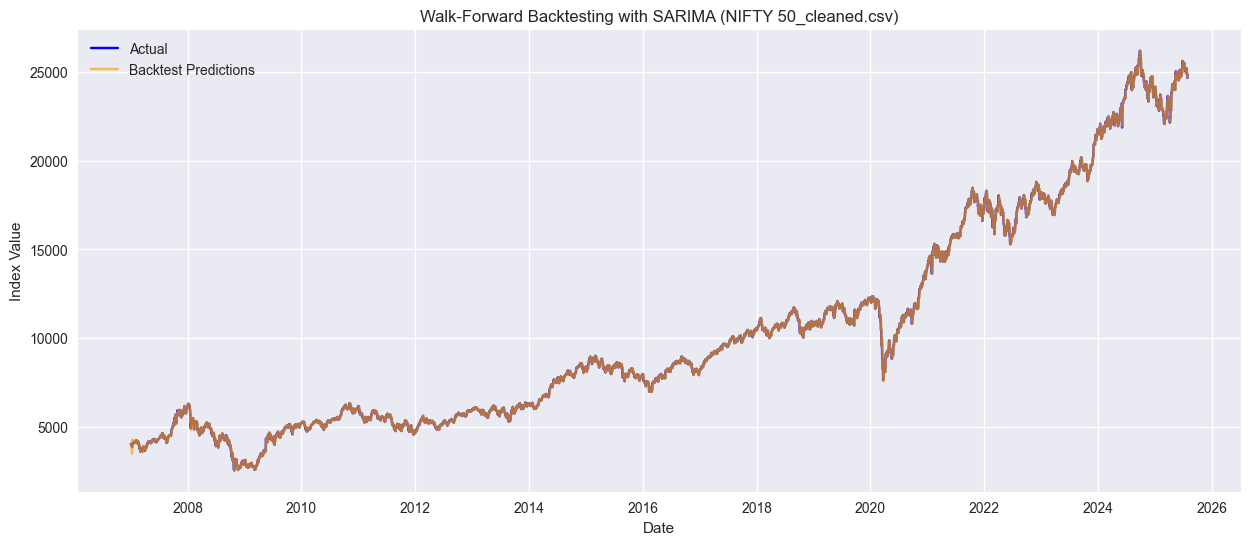

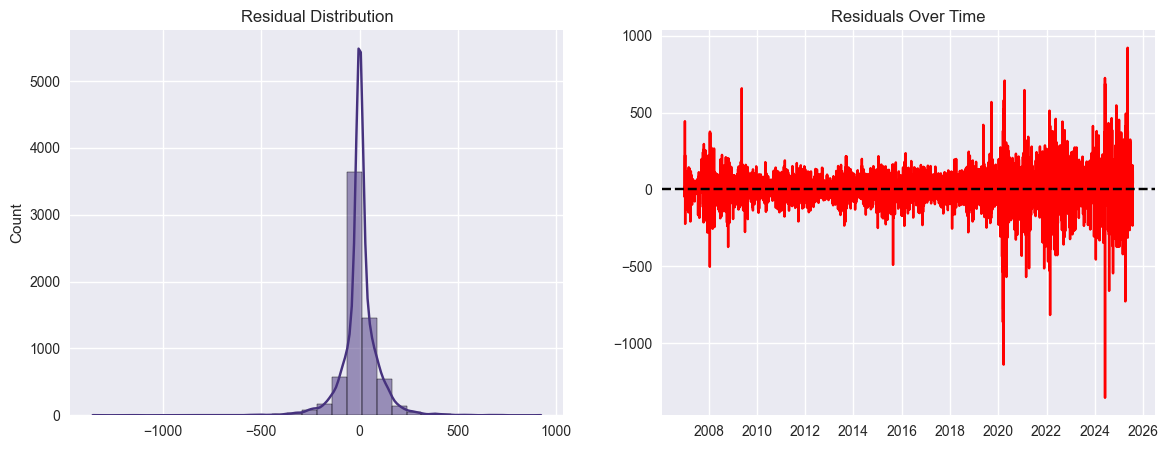

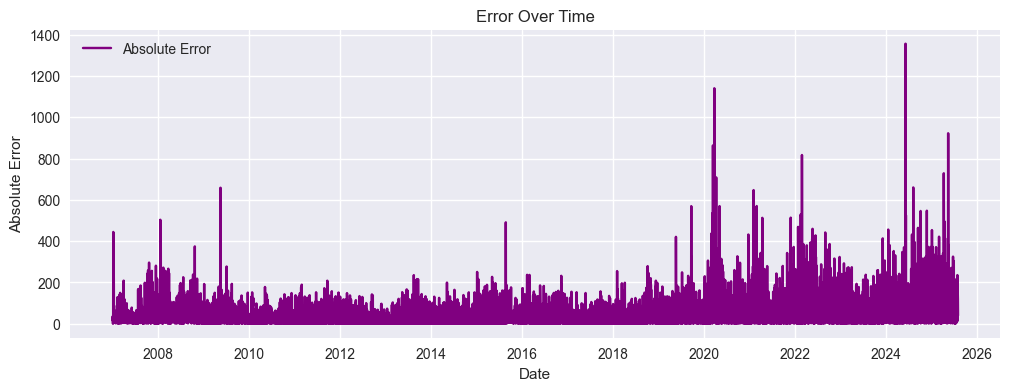

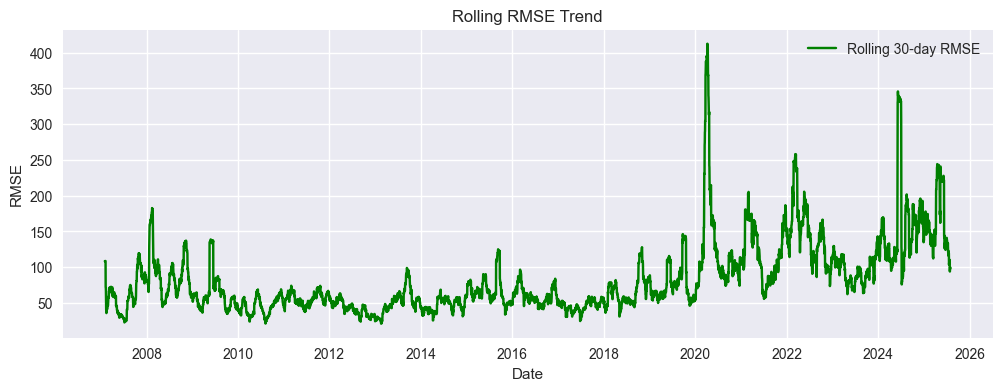


📂 Processing: NIFTY AUTO_cleaned.csv
🔍 Auto-tuning SARIMA order...
✅ Selected Order: (3, 1, 2), Seasonal: (0, 0, 0, 12)


  0%|          | 0/6784 [00:00<?, ?it/s]

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1235: RuntimeWarning:

invalid value encountered in divide

C:\Users\ch.en.u4aie22004\AppData\Roaming\

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



📈 Metrics for NIFTY AUTO_cleaned.csv
   RMSE: 102.4288
   MAE : 54.4531
   MAPE: 0.72%
   R²   : 0.9997


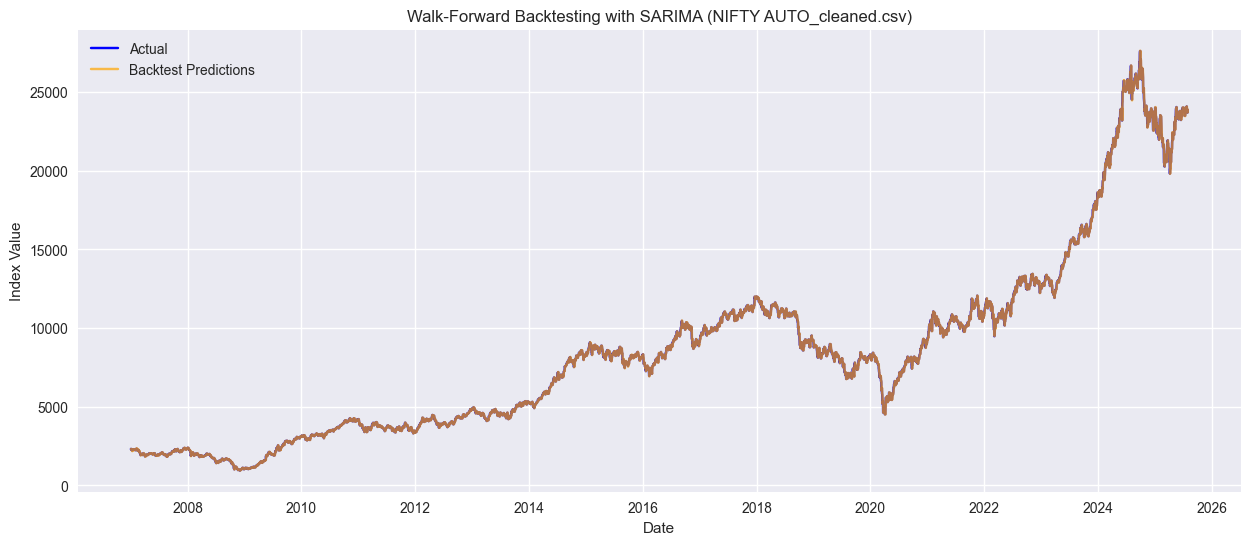

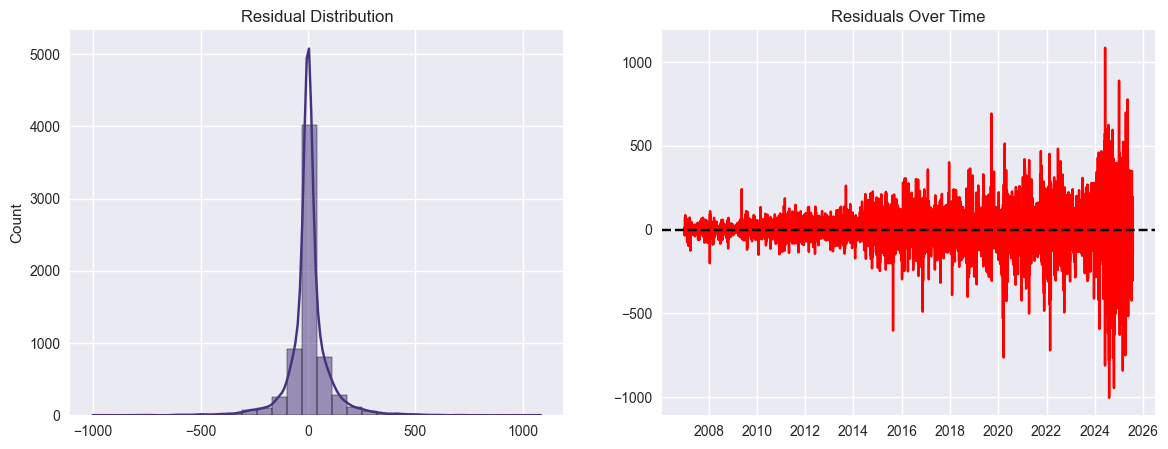

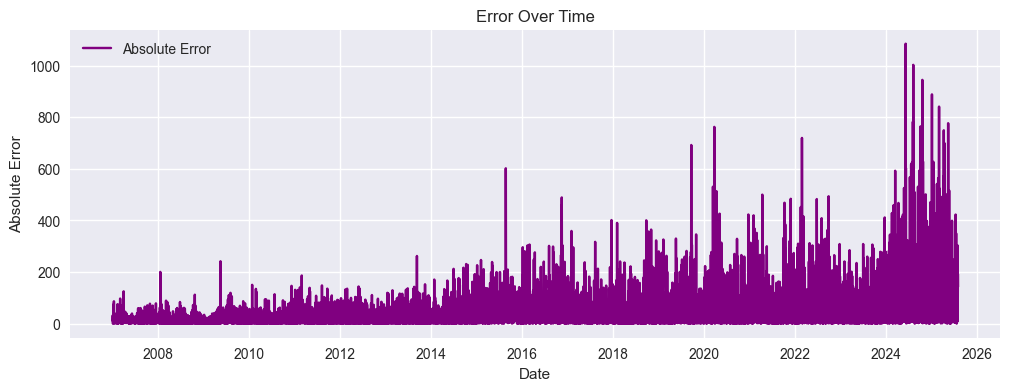

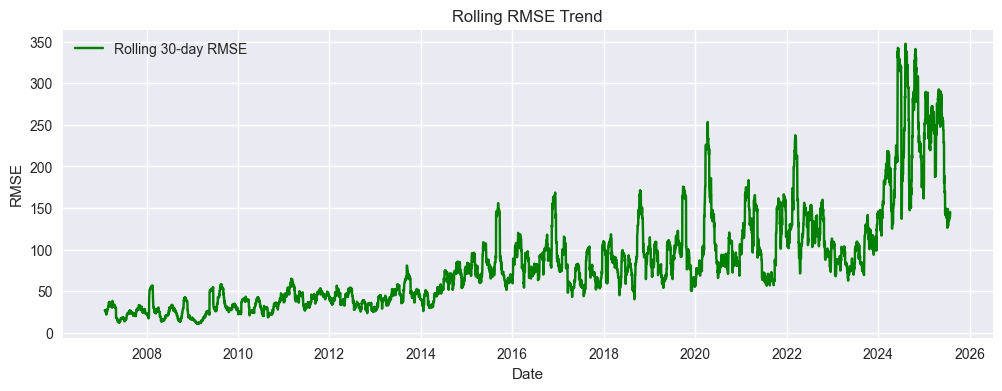


📂 Processing: NIFTY BANK_cleaned.csv
🔍 Auto-tuning SARIMA order...
✅ Selected Order: (2, 1, 2), Seasonal: (1, 0, 1, 12)


  0%|          | 0/6784 [00:00<?, ?it/s]

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameter

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\b

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

📈 Metrics for NIFTY BANK_cleaned.csv
   RMSE: 62164220707816128530453387653196883280921017985197562208952401264640.0000
   MAE : 754740358974532395309874674527394789193356129131040587037710221312.0000
   MAPE: 12920870686488889828562889028728804270838352804650569182352506880.00%
   R²   : -19485309244169076705521486876541263864281547313180810196504665311408639569198028804120900212549485523943408920182236099544875008.0000


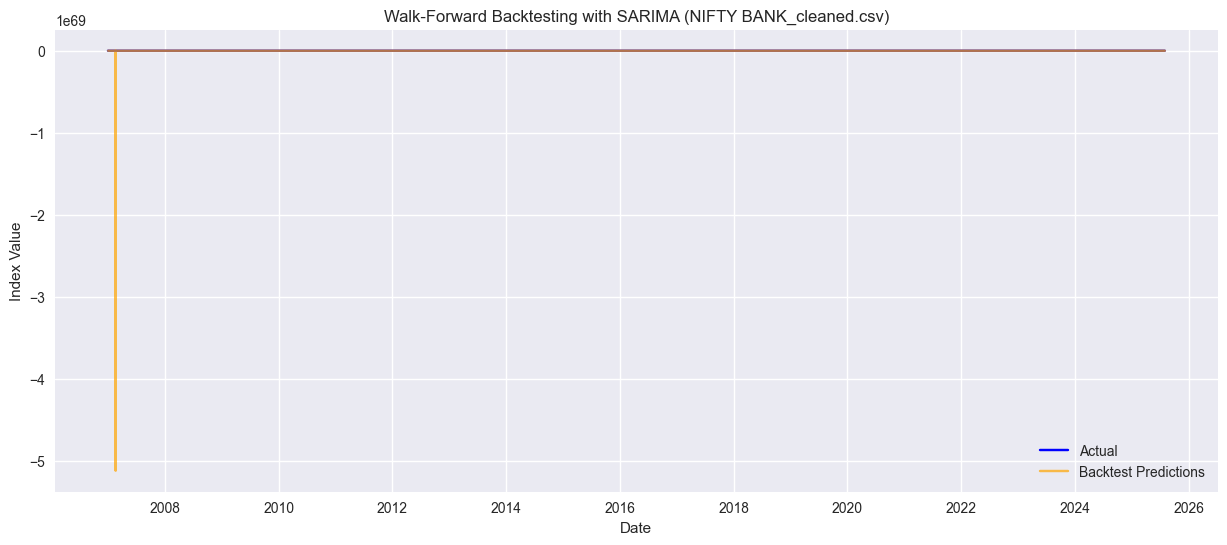

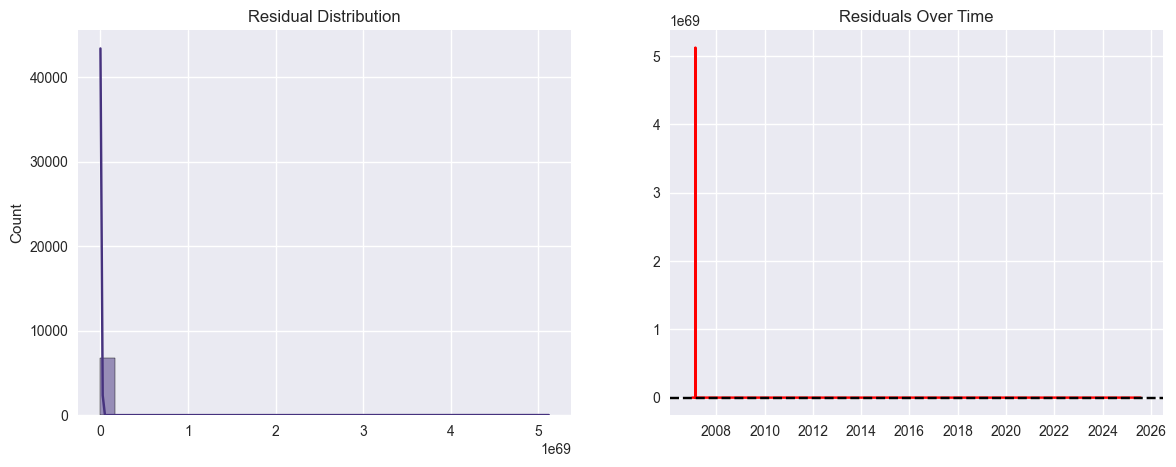

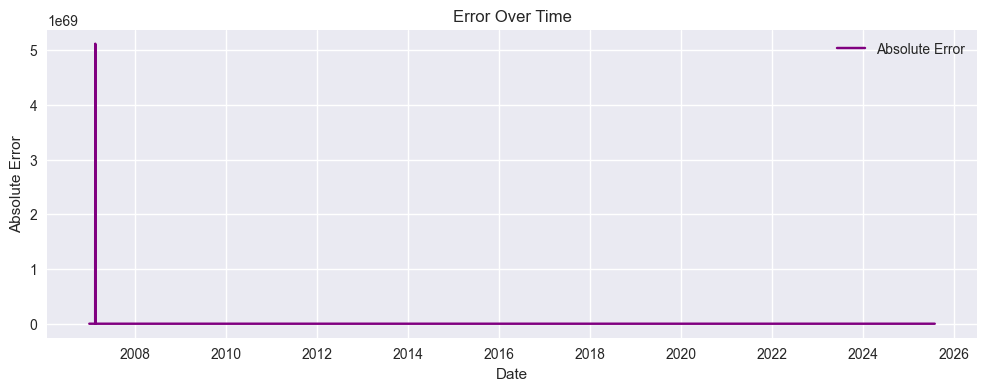

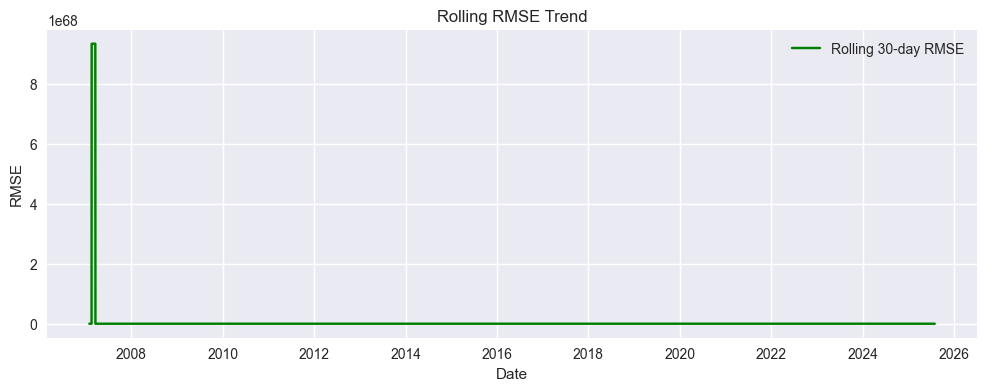


📂 Processing: NIFTY CHEMICALS_cleaned.csv
🔍 Auto-tuning SARIMA order...
✅ Selected Order: (5, 2, 0), Seasonal: (0, 0, 0, 12)


  0%|          | 0/6784 [00:00<?, ?it/s]

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:163: RuntimeWarning:

invalid value encountered in divide

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:198: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-pack

⚠️ Error processing C:/Users/ch.en.u4aie22004/Downloads/Indiansecs\NIFTY CHEMICALS_cleaned.csv: Input contains NaN.

📂 Processing: NIFTY CONSUMER DURABLES_cleaned.csv
🔍 Auto-tuning SARIMA order...
✅ Selected Order: (4, 1, 2), Seasonal: (2, 0, 0, 12)


  0%|          | 0/6784 [00:00<?, ?it/s]

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:163: RuntimeWarning:

invalid value encountered in divide

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:198: RuntimeWarning:

invalid value encountered in scalar divide

C:\

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1235: RuntimeWarning:

invalid value encountered in divide

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Py

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

📈 Metrics for NIFTY CONSUMER DURABLES_cleaned.csv
   RMSE: 5167309.4491
   MAE : 181443.3034
   MAPE: 641.94%
   R²   : -218275.3640


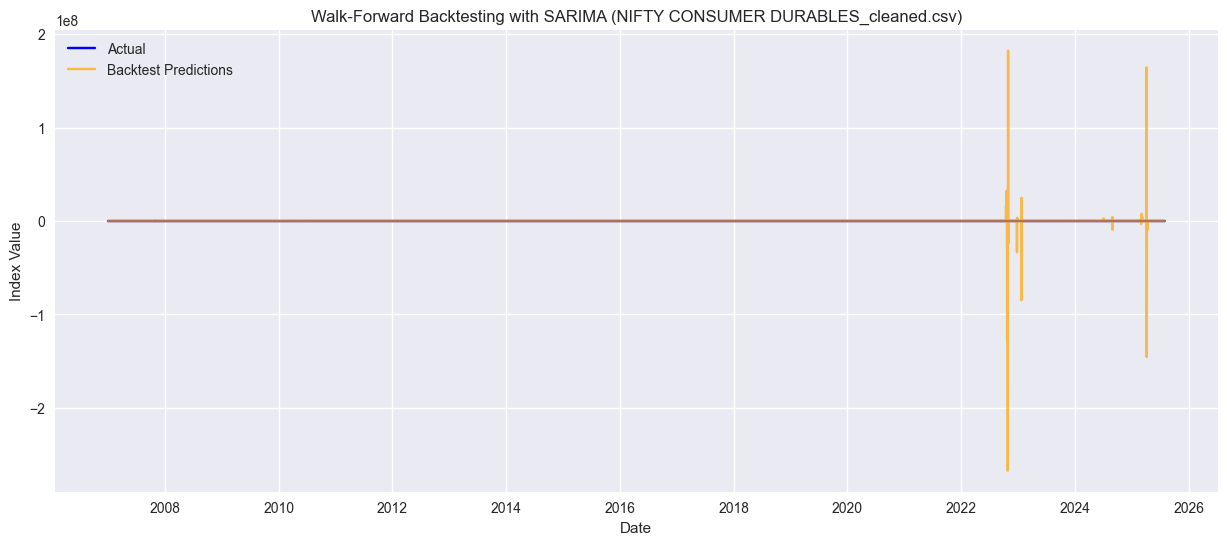

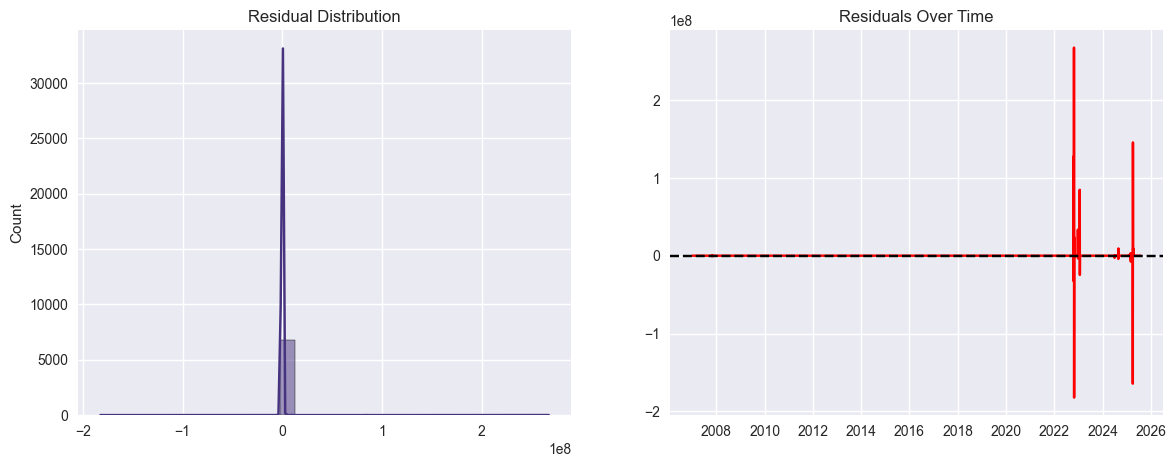

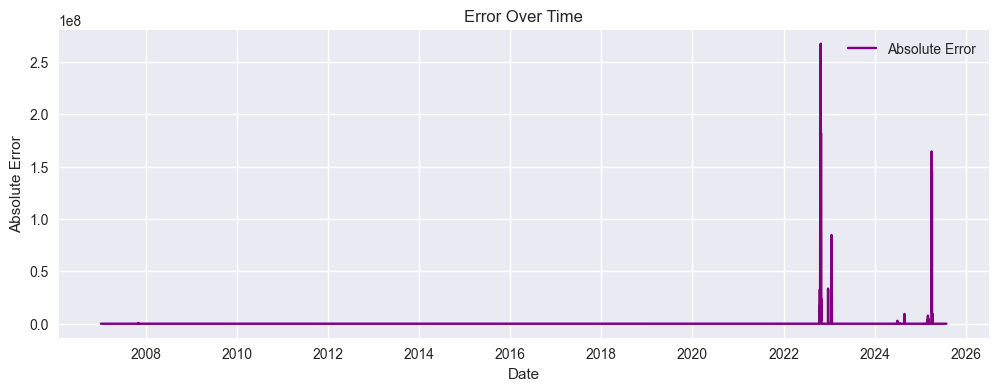

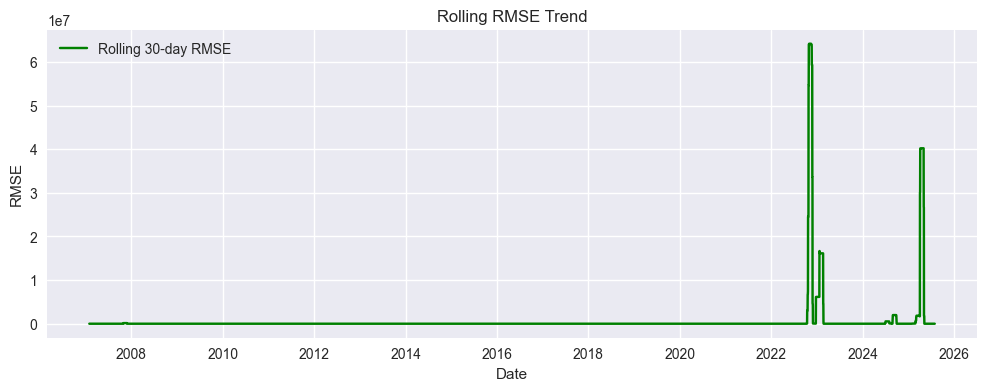


📂 Processing: NIFTY FINANCIAL SERVICES_cleaned.csv
🔍 Auto-tuning SARIMA order...
✅ Selected Order: (1, 1, 0), Seasonal: (0, 0, 0, 12)


  0%|          | 0/6784 [00:00<?, ?it/s]

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:163: RuntimeWarning:

invalid value encountered in divide

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:198: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-pack

📈 Metrics for NIFTY FINANCIAL SERVICES_cleaned.csv
   RMSE: 119.0296
   MAE : 62.6854
   MAPE: 0.79%
   R²   : 0.9997


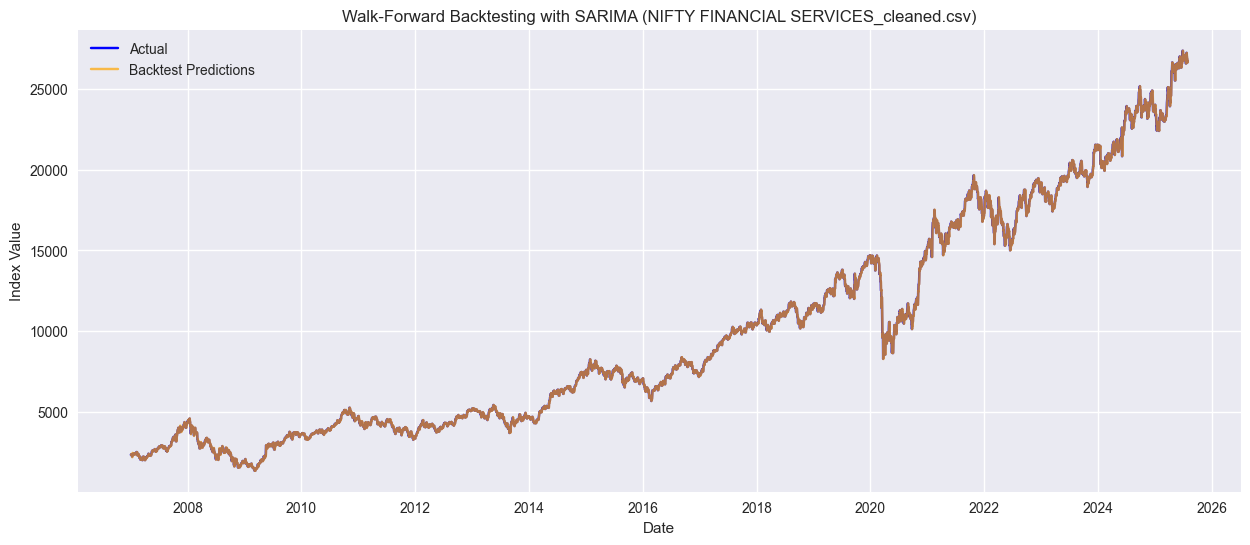

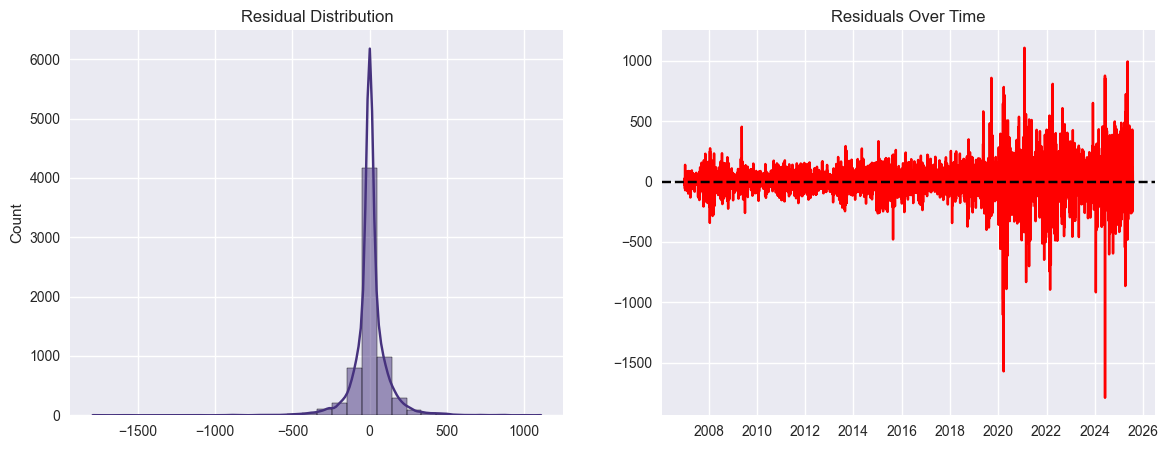

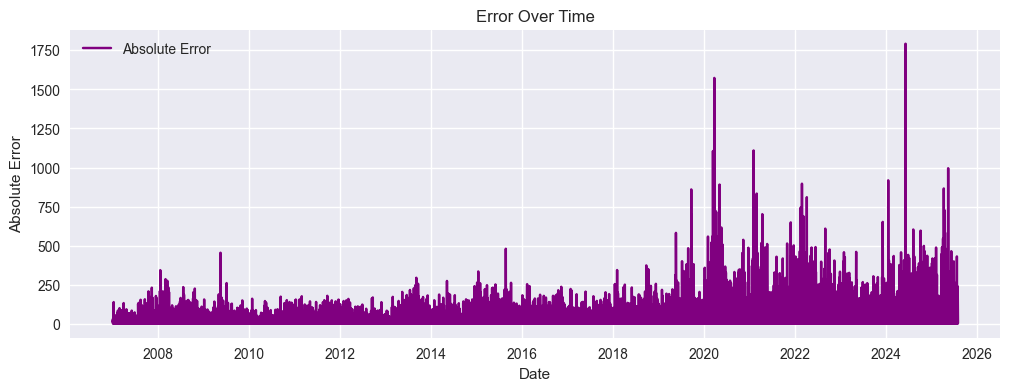

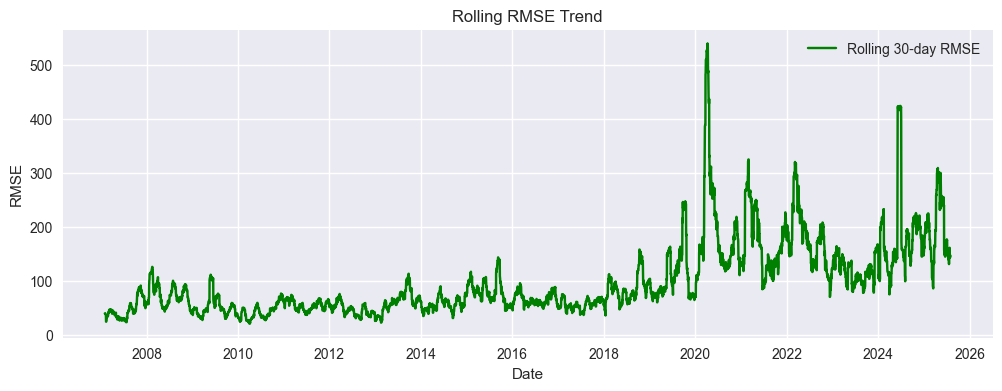


📂 Processing: NIFTY FMCG_cleaned.csv
🔍 Auto-tuning SARIMA order...
✅ Selected Order: (3, 1, 1), Seasonal: (0, 0, 0, 12)


  0%|          | 0/6784 [00:00<?, ?it/s]

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1235: RuntimeWarning:

invalid value encountered in divide

C:\Users\ch.en.u4aie22004\AppData\Roaming\

📈 Metrics for NIFTY FMCG_cleaned.csv
   RMSE: 228.5548
   MAE : 123.6053
   MAPE: 0.58%
   R²   : 0.9998


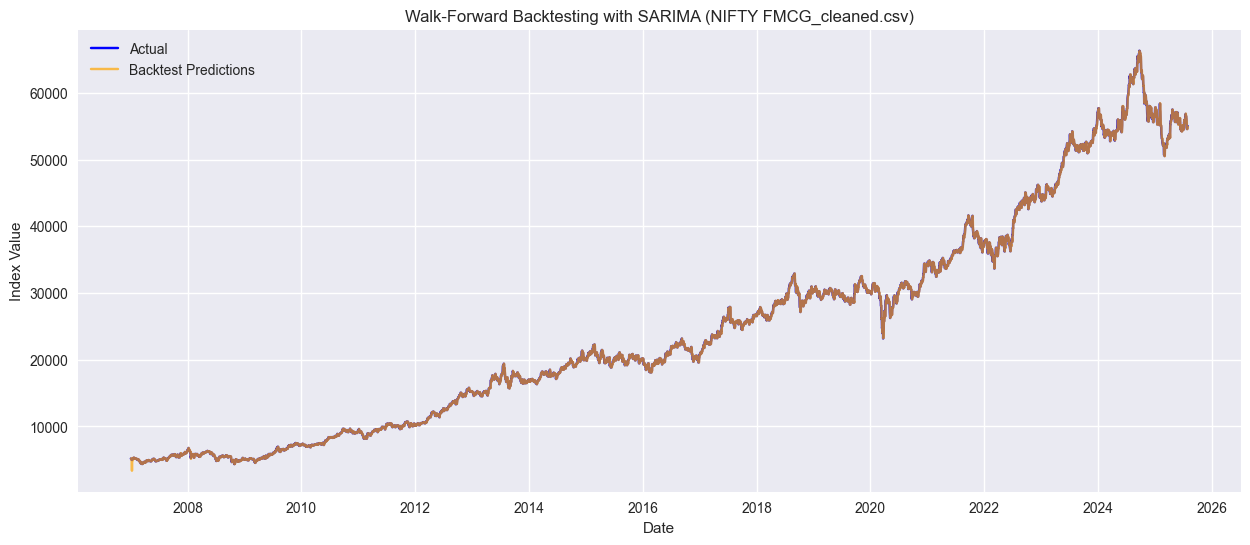

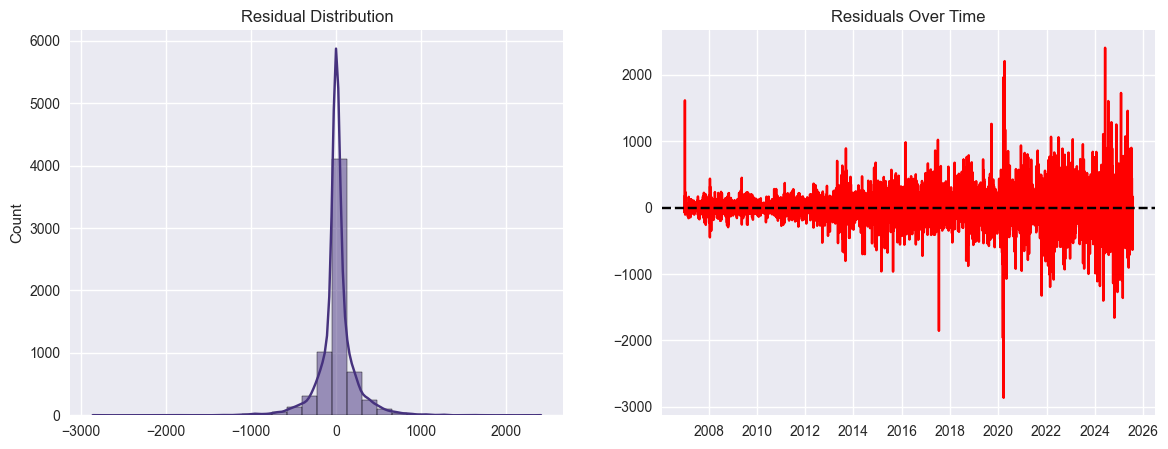

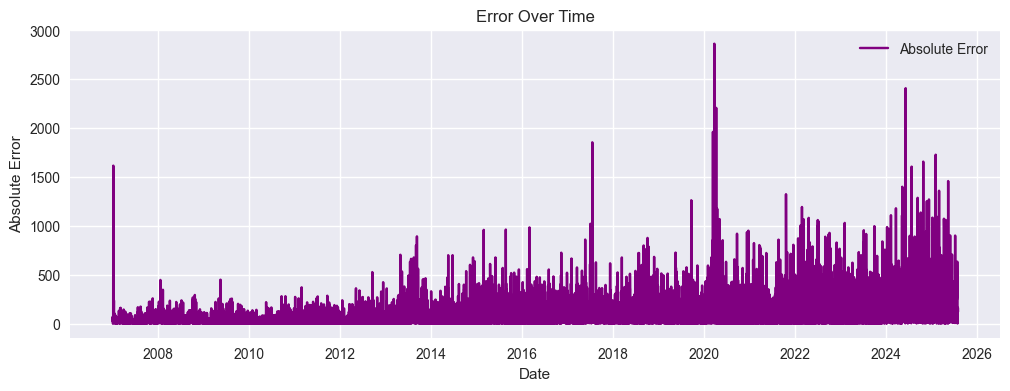

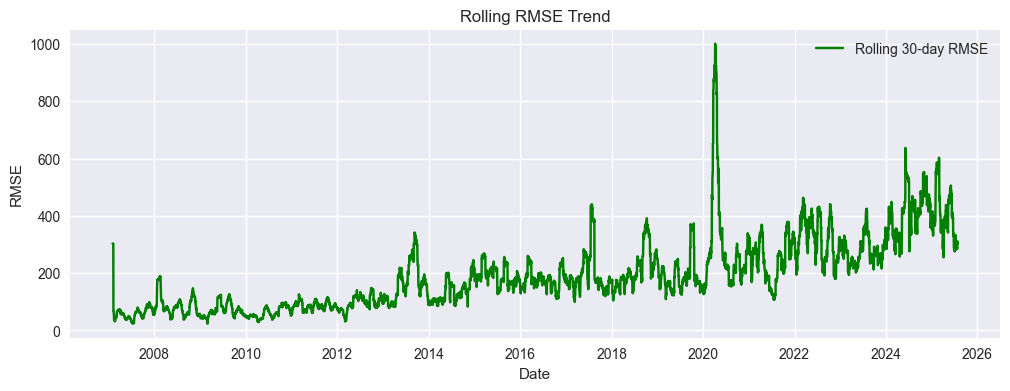


📂 Processing: NIFTY HEALTHCARE_cleaned.csv
⚠️ Error processing C:/Users/ch.en.u4aie22004/Downloads/Indiansecs\NIFTY HEALTHCARE_cleaned.csv: cannot reindex on an axis with duplicate labels

📂 Processing: NIFTY IT_cleaned.csv
🔍 Auto-tuning SARIMA order...
✅ Selected Order: (3, 1, 2), Seasonal: (0, 0, 0, 12)


  0%|          | 0/6784 [00:00<?, ?it/s]

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1235: RuntimeWarning:

invalid value encountered in divide

C:\Users\ch.en.u4aie22004\AppData\Roaming\

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

📈 Metrics for NIFTY IT_cleaned.csv
   RMSE: 239.9752
   MAE : 105.2571
   MAPE: 0.78%
   R²   : 0.9996


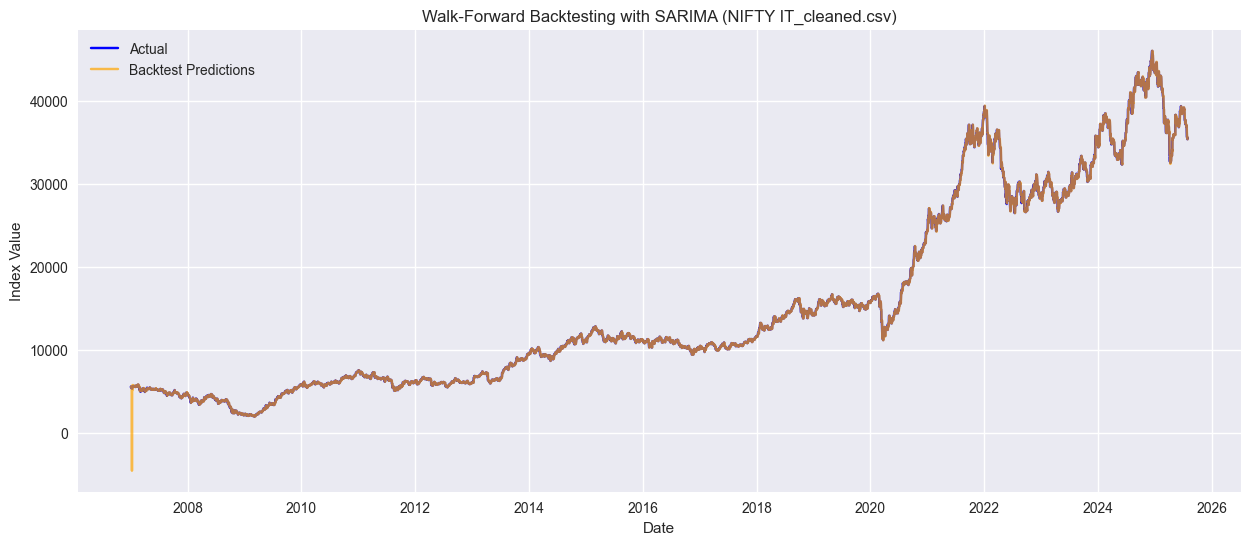

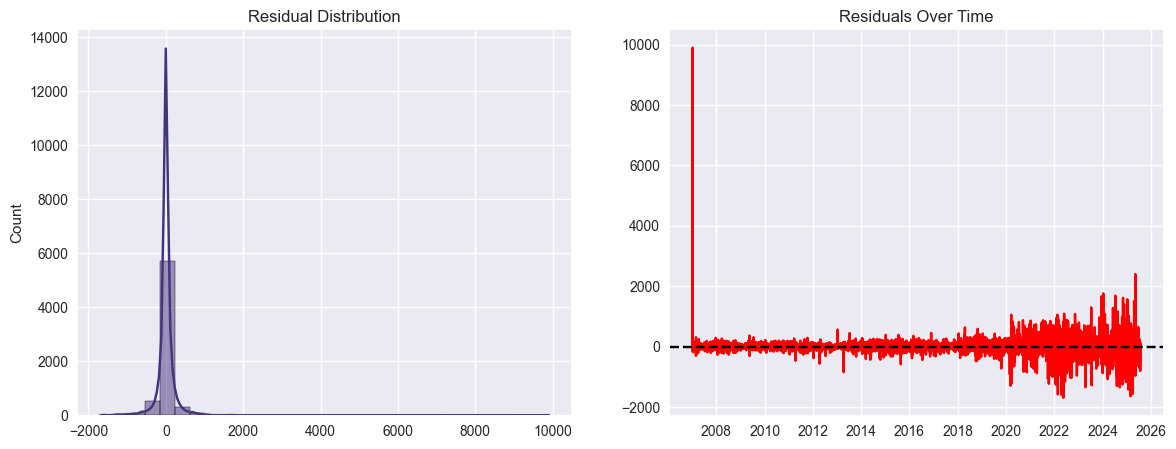

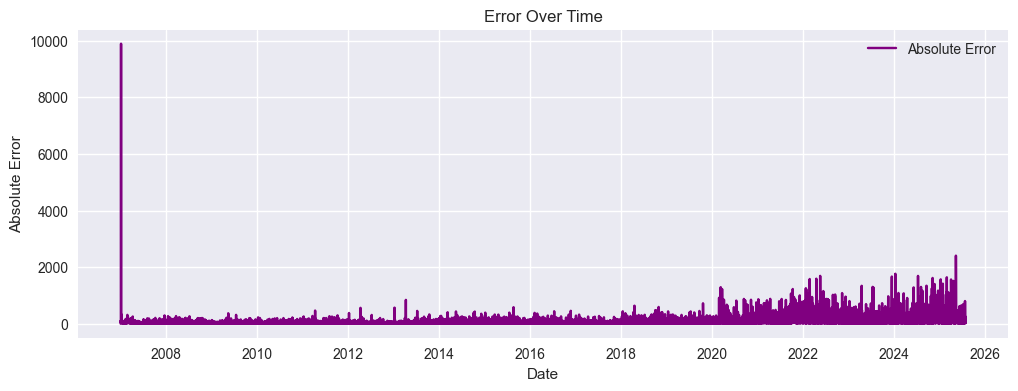

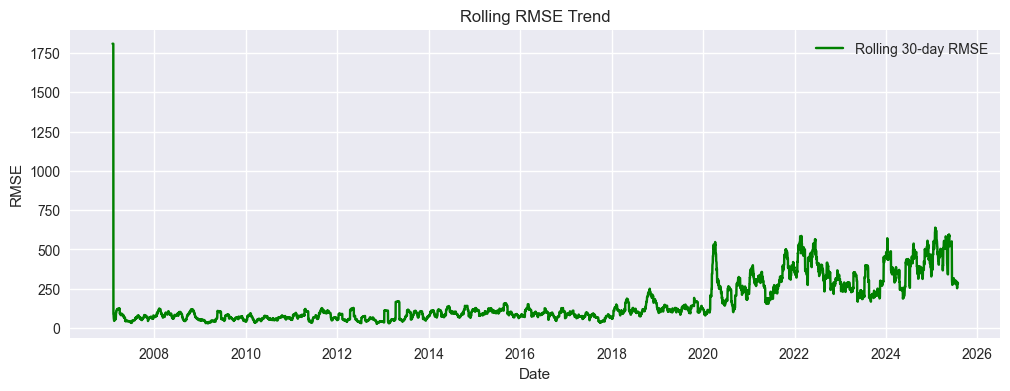


📂 Processing: NIFTY MEDIA_cleaned.csv
🔍 Auto-tuning SARIMA order...
✅ Selected Order: (0, 1, 0), Seasonal: (0, 0, 0, 12)


  0%|          | 0/6784 [00:00<?, ?it/s]

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1235: RuntimeWarning:

invalid value encountered in divide



📈 Metrics for NIFTY MEDIA_cleaned.csv
   RMSE: 27.1889
   MAE : 15.8214
   MAPE: 0.85%
   R²   : 0.9977


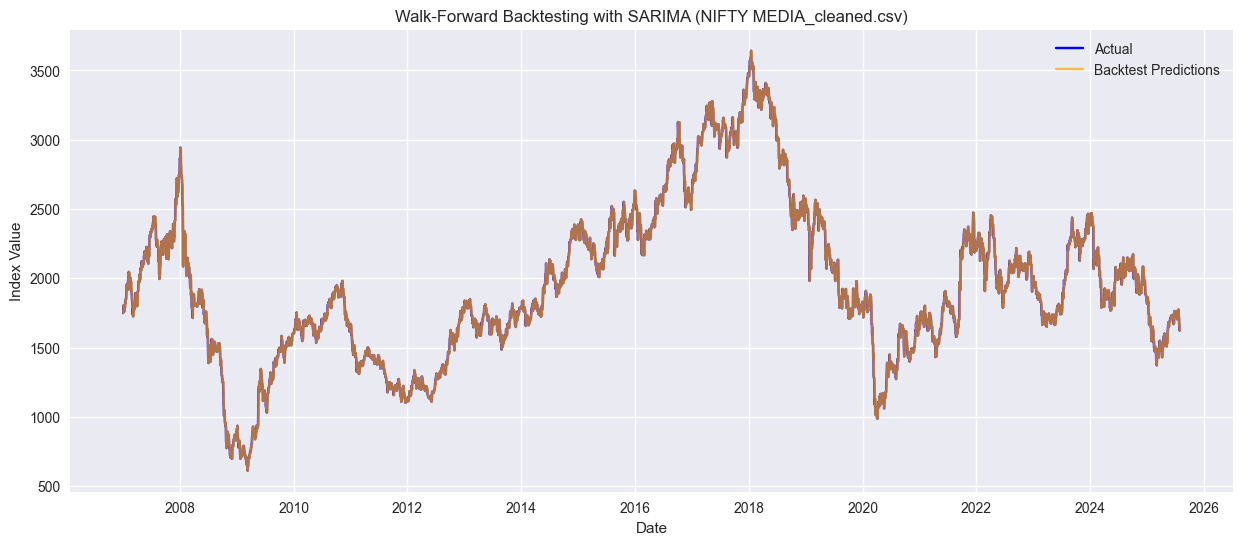

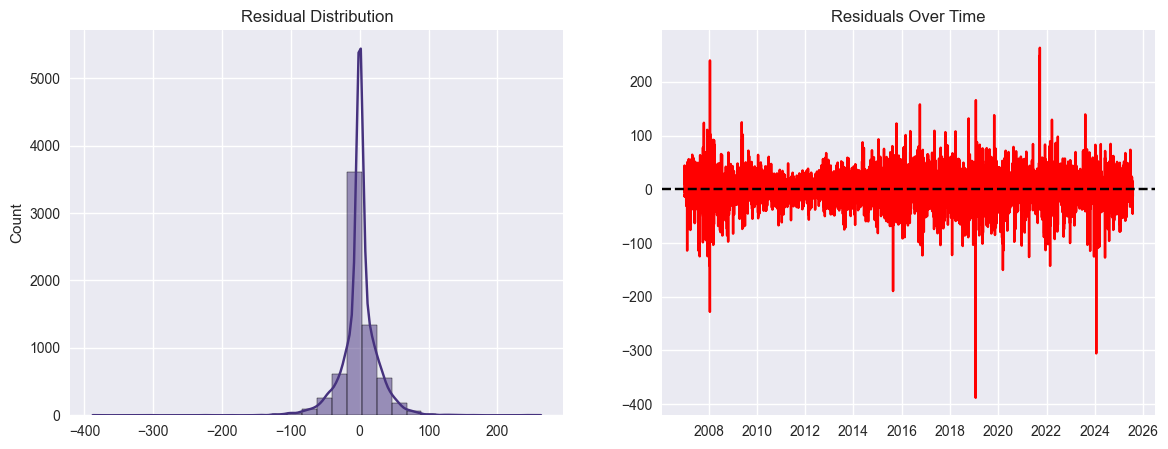

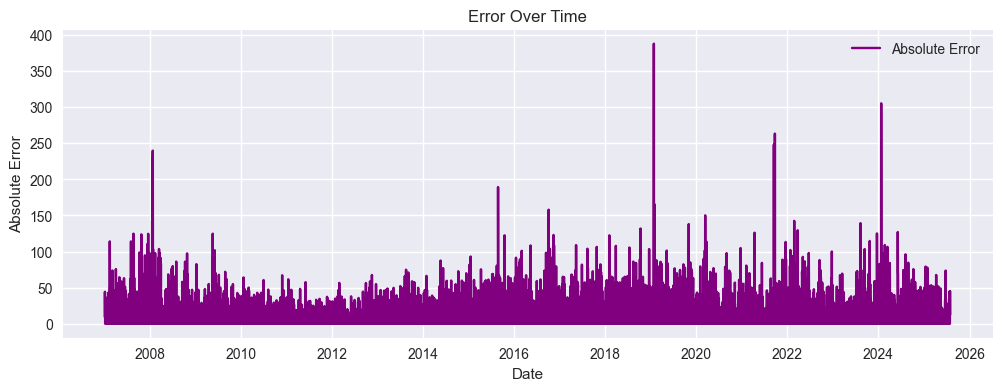

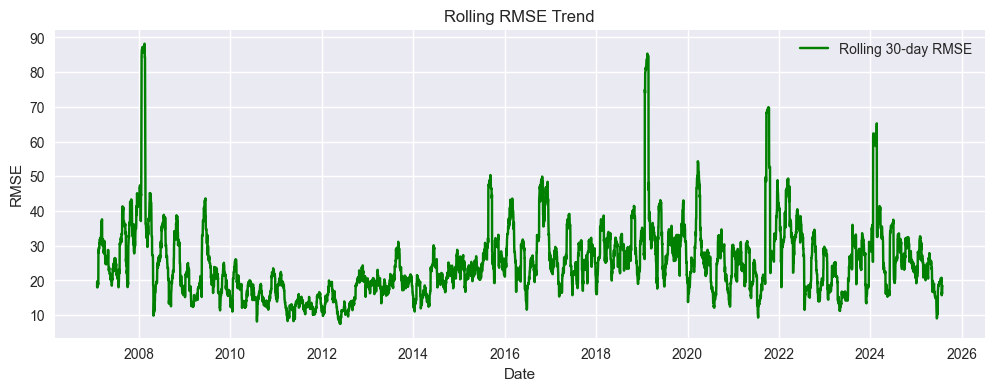


📂 Processing: NIFTY METAL_cleaned.csv
🔍 Auto-tuning SARIMA order...
✅ Selected Order: (3, 1, 0), Seasonal: (0, 0, 0, 12)


  0%|          | 0/6784 [00:00<?, ?it/s]

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:163: RuntimeWarning:

invalid value encountered in divide

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:198: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-pack

📈 Metrics for NIFTY METAL_cleaned.csv
   RMSE: 72.0335
   MAE : 37.4600
   MAPE: 1.02%
   R²   : 0.9987


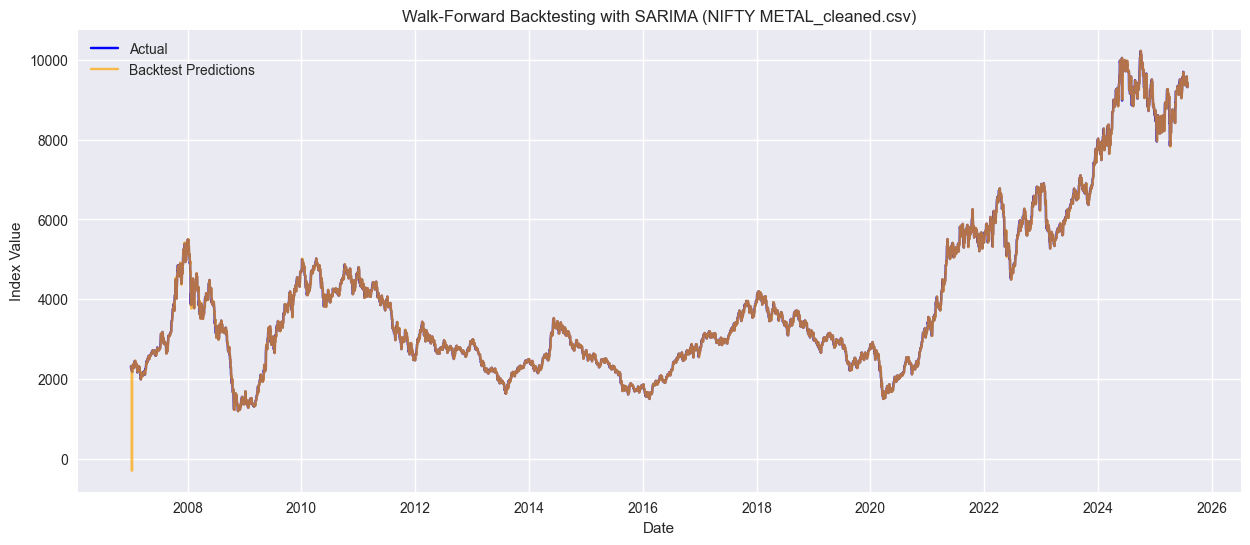

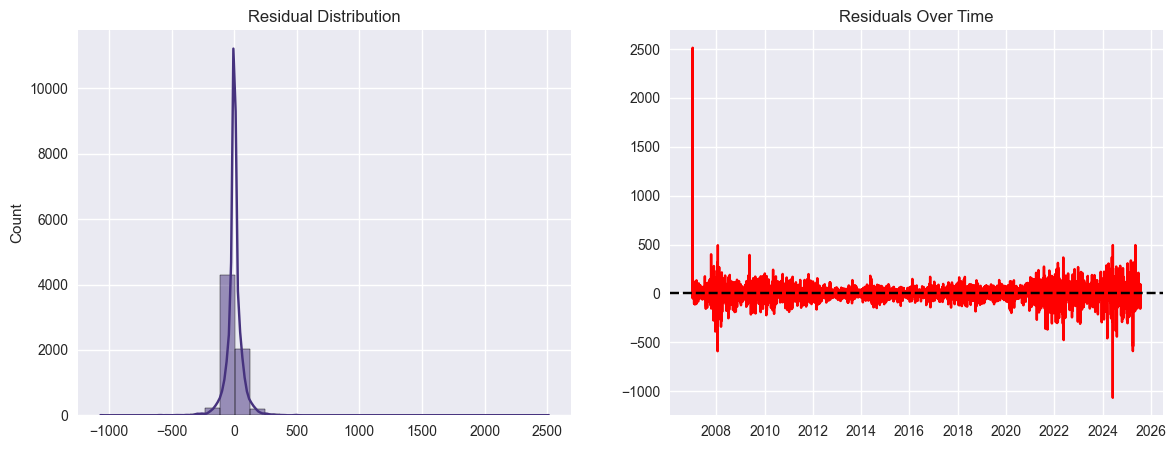

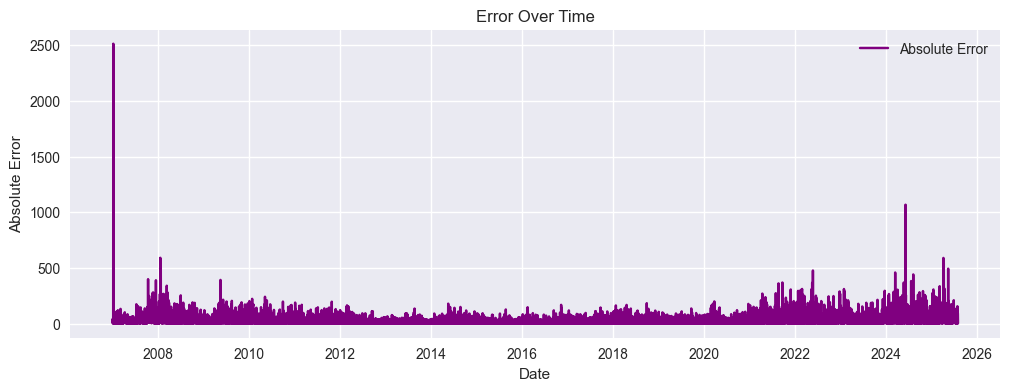

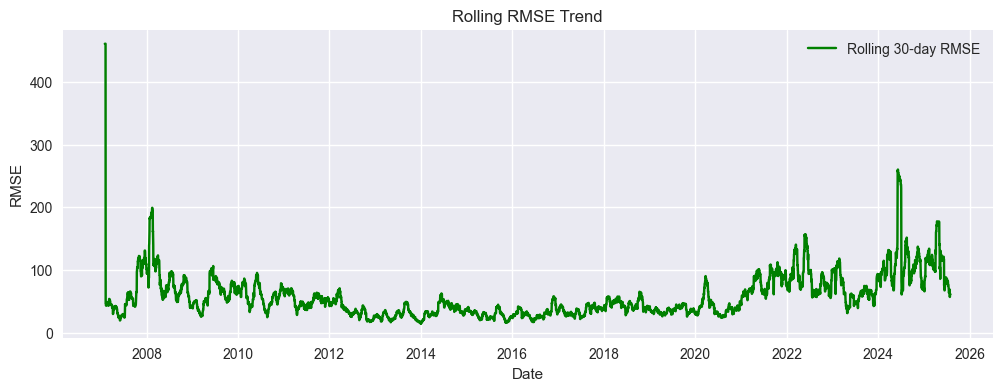


📂 Processing: NIFTY PHARMA_cleaned.csv
🔍 Auto-tuning SARIMA order...
✅ Selected Order: (3, 1, 3), Seasonal: (0, 0, 0, 12)


  0%|          | 0/6784 [00:00<?, ?it/s]

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All paramet

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

📈 Metrics for NIFTY PHARMA_cleaned.csv
   RMSE: 98.8243
   MAE : 56.0143
   MAPE: 0.63%
   R²   : 0.9996


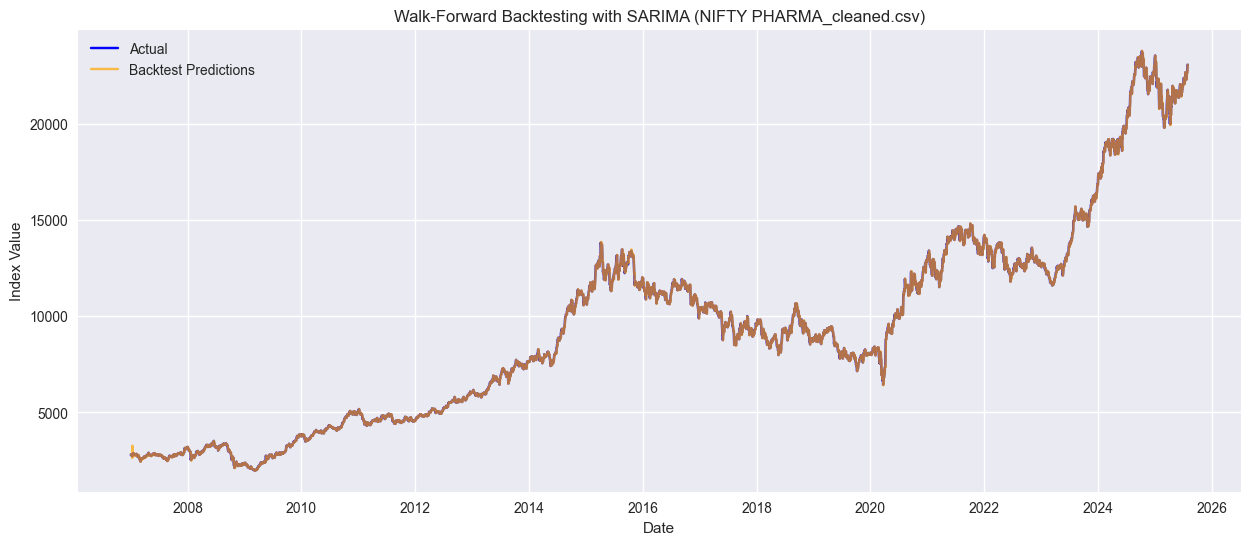

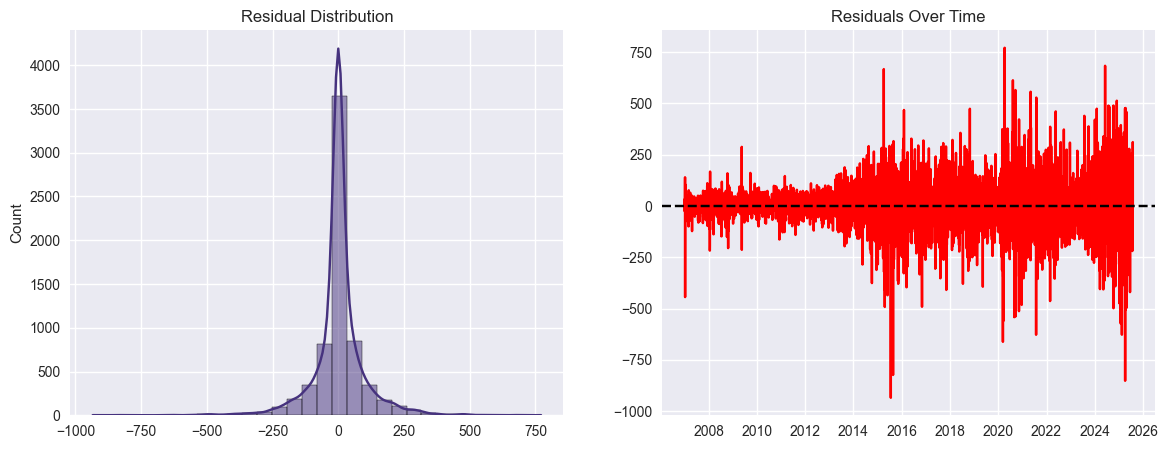

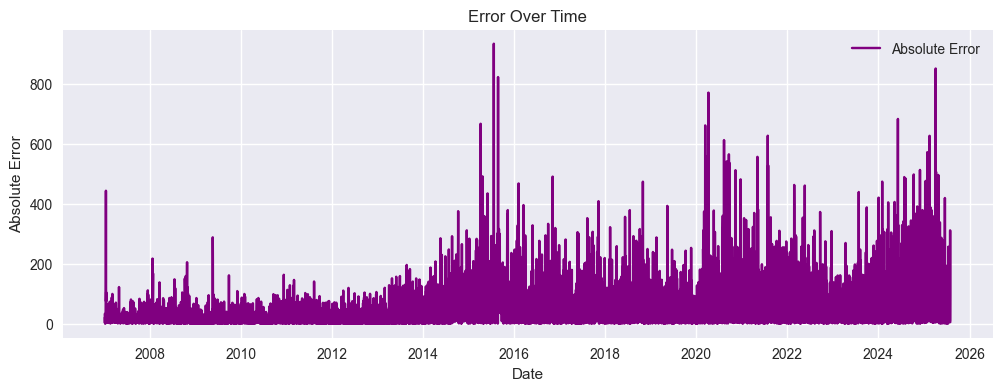

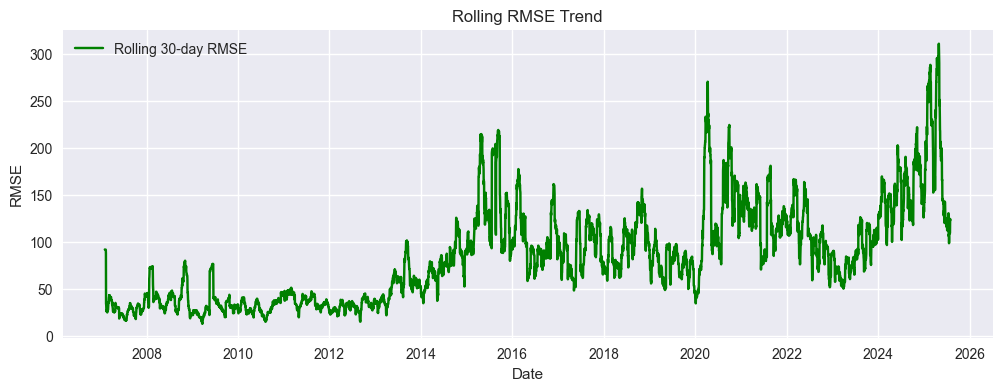


📂 Processing: NIFTY PRIVATE BANK_cleaned.csv
🔍 Auto-tuning SARIMA order...
✅ Selected Order: (0, 1, 0), Seasonal: (0, 0, 0, 12)


  0%|          | 0/6784 [00:00<?, ?it/s]

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1235: RuntimeWarning:

invalid value encountered in divide



📈 Metrics for NIFTY PRIVATE BANK_cleaned.csv
   RMSE: 140.7997
   MAE : 74.2532
   MAPE: 0.82%
   R²   : 0.9996


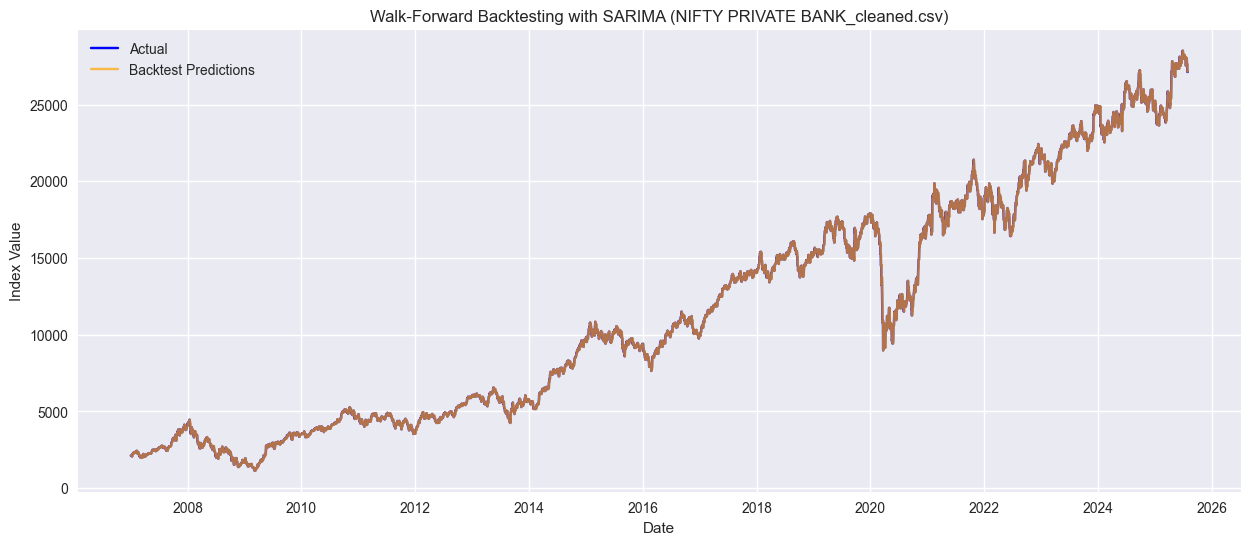

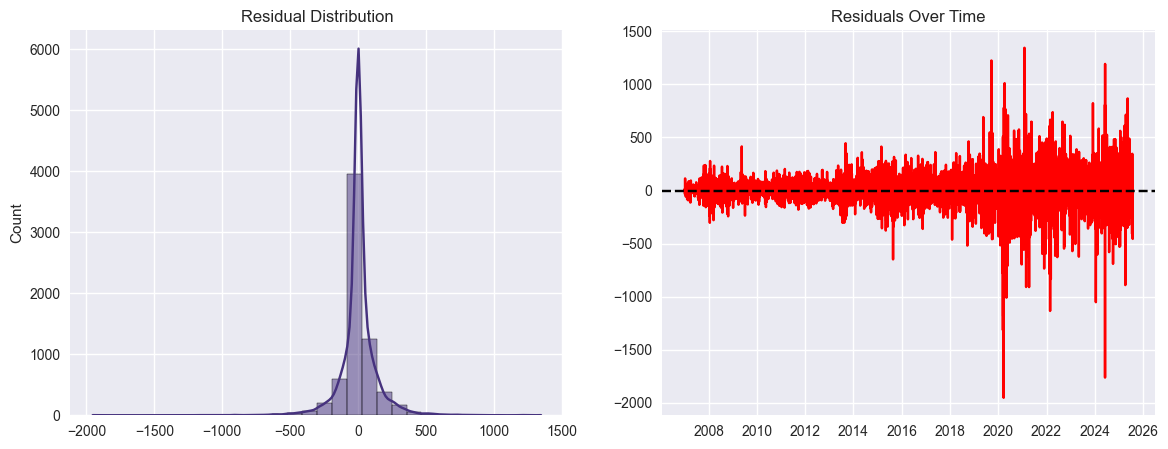

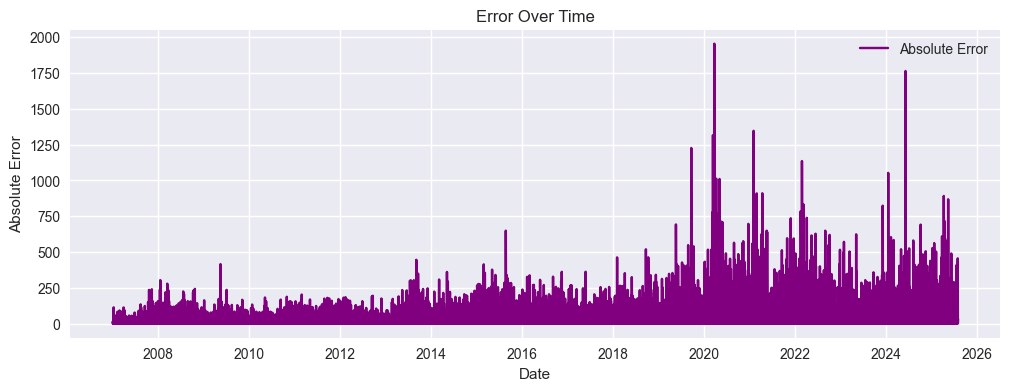

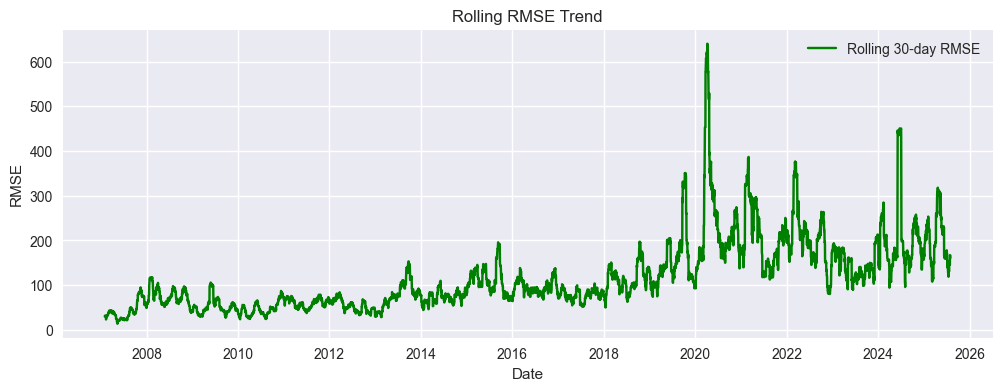


📂 Processing: NIFTY PSU BANK_cleaned.csv
🔍 Auto-tuning SARIMA order...
✅ Selected Order: (4, 1, 3), Seasonal: (0, 0, 0, 12)


  0%|          | 0/6784 [00:00<?, ?it/s]

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All paramet

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie

📈 Metrics for NIFTY PSU BANK_cleaned.csv
   RMSE: 58.0442
   MAE : 34.5020
   MAPE: 1.12%
   R²   : 0.9981


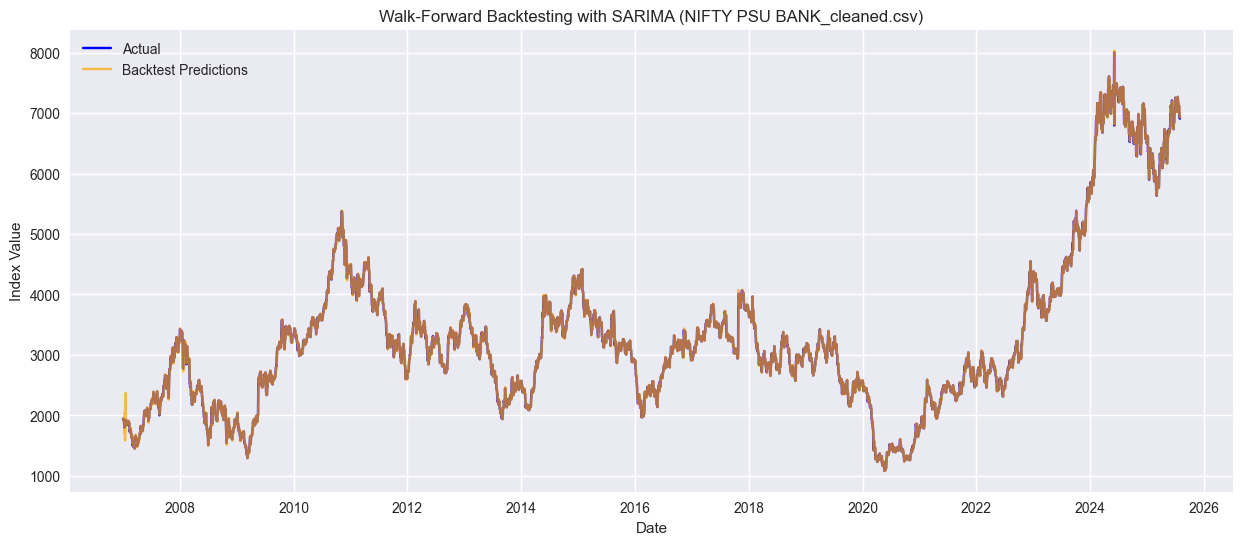

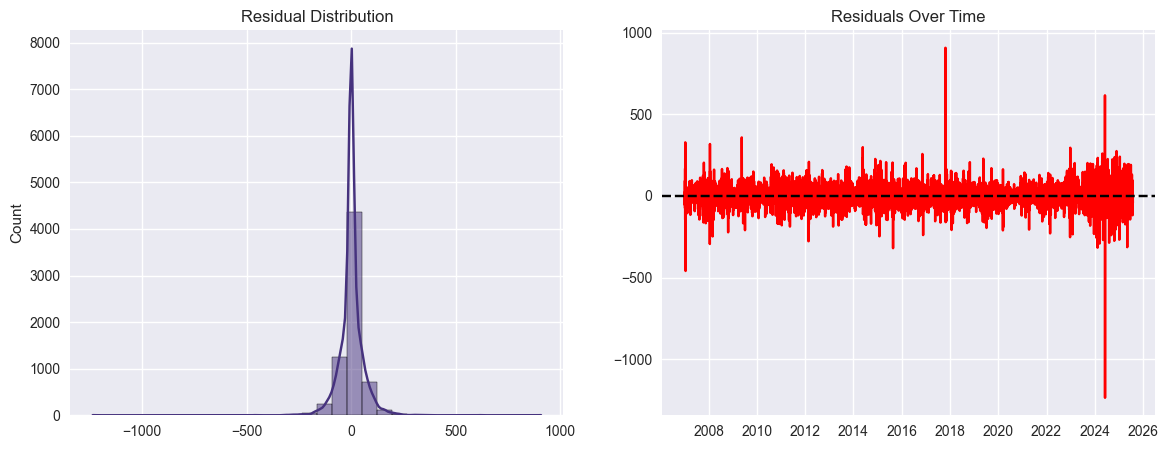

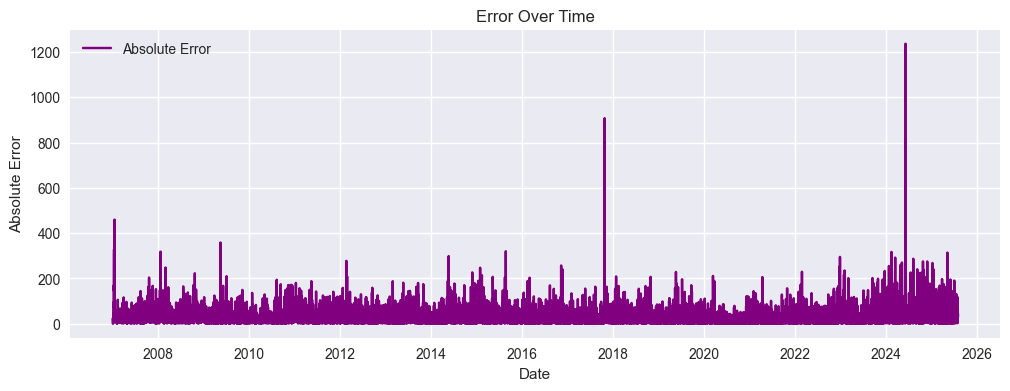

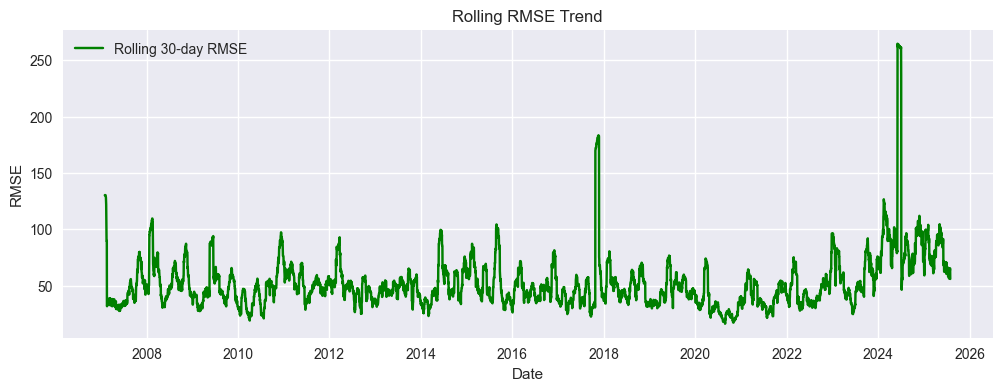


📂 Processing: NIFTY REALTY_cleaned.csv
🔍 Auto-tuning SARIMA order...
✅ Selected Order: (3, 1, 0), Seasonal: (1, 0, 1, 12)


  0%|          | 0/6784 [00:00<?, ?it/s]

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:163: RuntimeWarning:

invalid value encountered in divide

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:198: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\ch.en.u4aie22004\AppData\Roaming\Python\Python310\site-packages\statsmodels\b

📈 Metrics for NIFTY REALTY_cleaned.csv
   RMSE: 12.4709
   MAE : 5.5370
   MAPE: 1.24%
   R²   : 0.9983


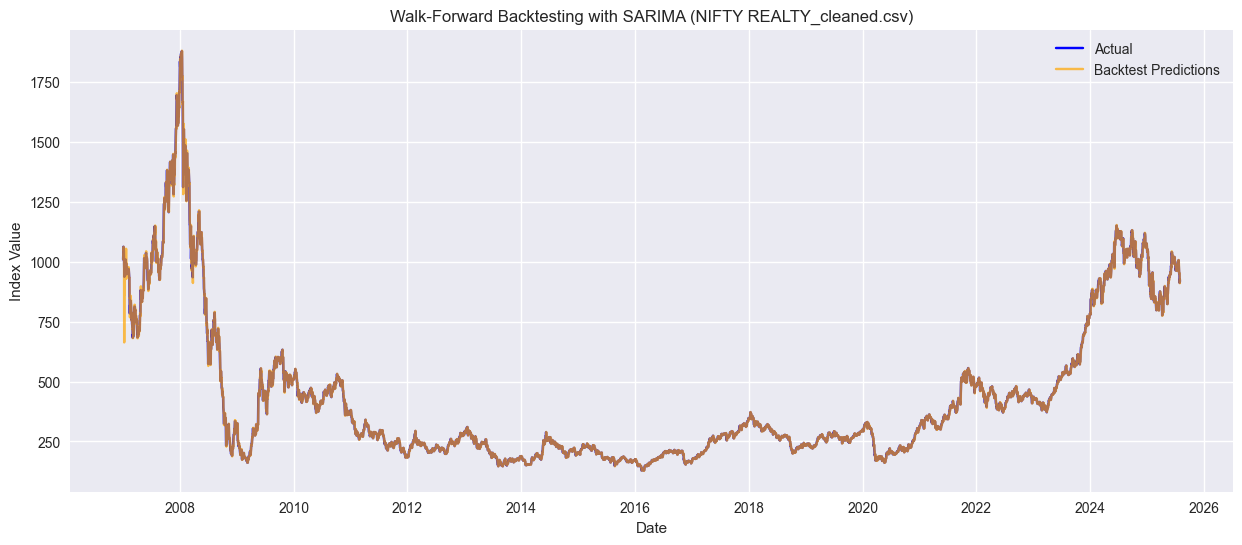

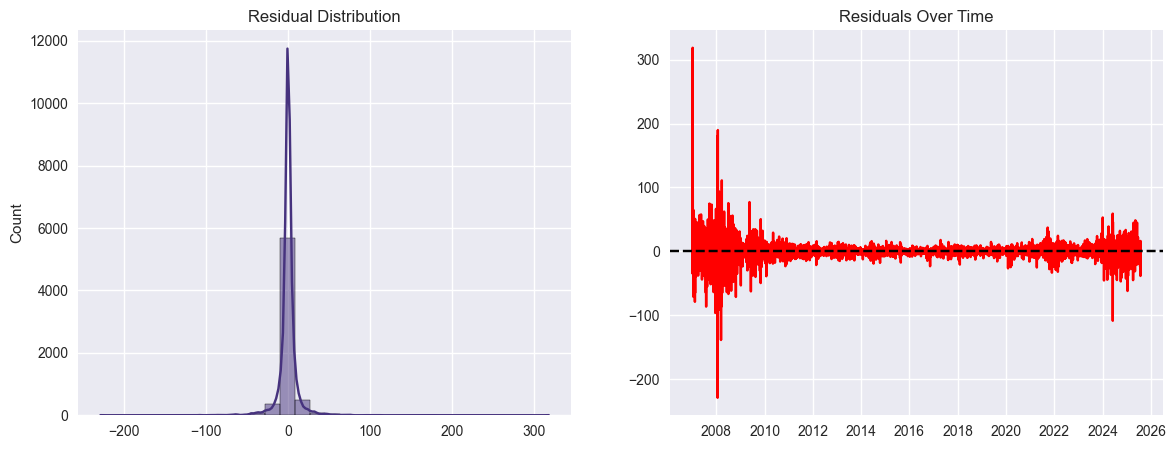

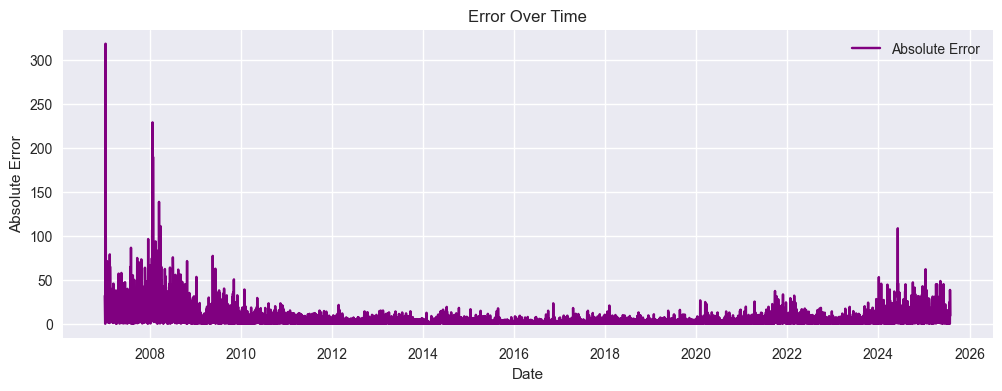

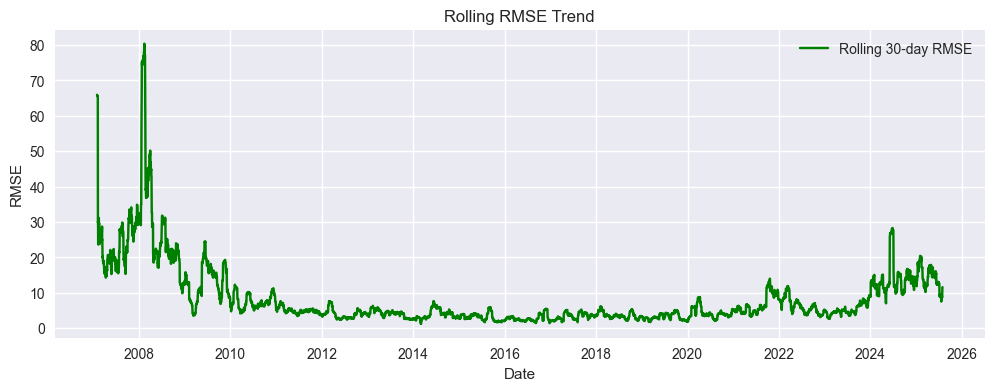

file          rmse           mae  \
0                   NIFTY 50_cleaned.csv  9.639867e+01  5.389443e+01   
1                 NIFTY AUTO_cleaned.csv  1.024288e+02  5.445306e+01   
2                 NIFTY BANK_cleaned.csv  6.216422e+67  7.547404e+65   
3    NIFTY CONSUMER DURABLES_cleaned.csv  5.167309e+06  1.814433e+05   
4   NIFTY FINANCIAL SERVICES_cleaned.csv  1.190296e+02  6.268538e+01   
5                 NIFTY FMCG_cleaned.csv  2.285548e+02  1.236053e+02   
6                   NIFTY IT_cleaned.csv  2.399752e+02  1.052571e+02   
7                NIFTY MEDIA_cleaned.csv  2.718888e+01  1.582137e+01   
8                NIFTY METAL_cleaned.csv  7.203352e+01  3.746003e+01   
9               NIFTY PHARMA_cleaned.csv  9.882428e+01  5.601433e+01   
10        NIFTY PRIVATE BANK_cleaned.csv  1.407997e+02  7.425318e+01   
11            NIFTY PSU BANK_cleaned.csv  5.804418e+01  3.450198e+01   
12              NIFTY REALTY_cleaned.csv  1.247087e+01  5.537007e+00   

            mape             r2  
0   6.126051e-01   9.997413e-01  
1   7.188563e-01   9.996905e-01  
2   1.292087e+64 -1.948531e+127  
3   6.419362e+02  -2.182754e+05  
4   7.870799e-01   9.996801e-01  
5   5.757118e-01   9.997915e-01  
6   7.801002e-01   9.995517e-01  
7   8.476357e-01   9.977147e-01  
8   1.024992e+00   9.987341e-01  
9   6.301678e-01   9.996307e-01  
10  8.162595e-01   9.996435e-01  
11  1.121978e+00   9.980848e-01  
12  1.241933e+00   9.983340e-01

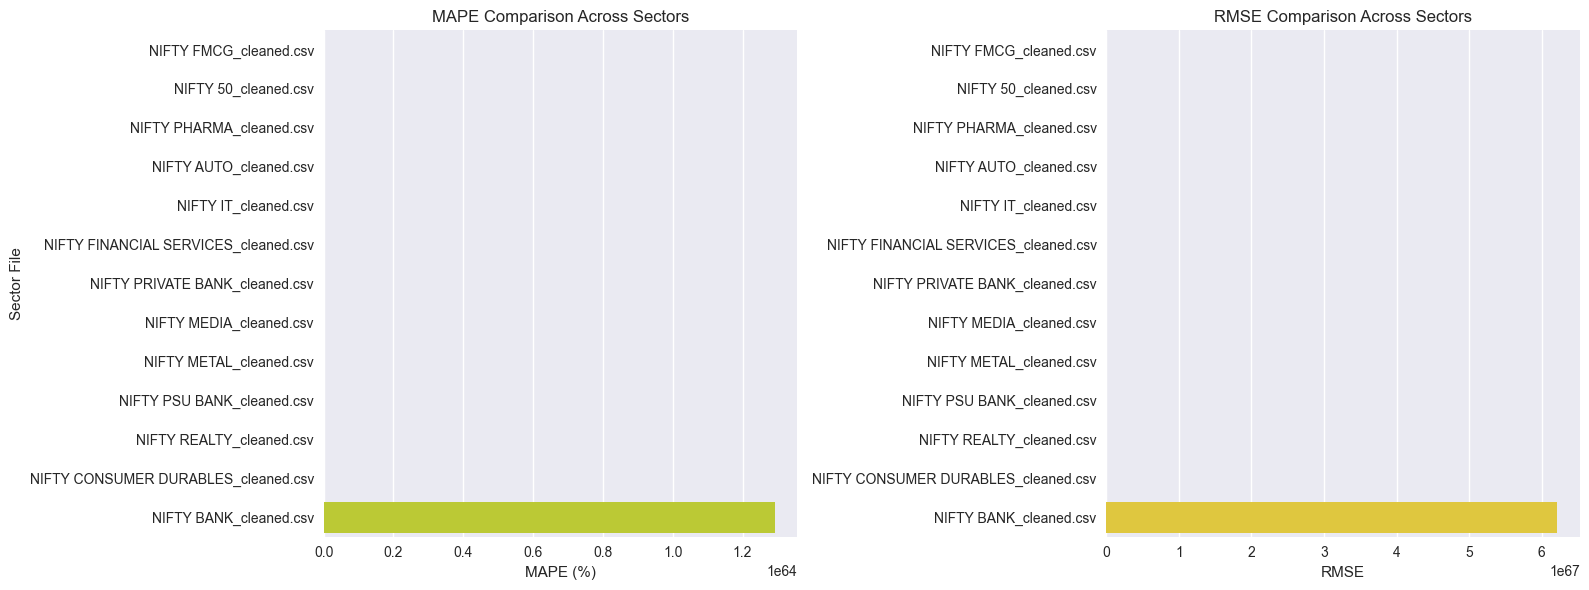

In [4]:
# 📌 Block C (Final): Run Backtesting for All Sectoral Files + Comparison Plot
file_list = glob.glob("C:/Users/ch.en.u4aie22004/Downloads/Indiansecs/*.csv")

results = []
for file in file_list:
    try:
        metrics = backtest_sarima(file)
        results.append(metrics)
    except Exception as e:
        print(f"⚠️ Error processing {file}: {e}")

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(results)
display(metrics_df)

# 📊 Comparison Bar Charts (MAPE + RMSE across all sectors)
fig, axes = plt.subplots(1, 2, figsize=(16,6))

metrics_df.sort_values("mape", inplace=True)

sns.barplot(x="mape", y="file", data=metrics_df, ax=axes[0], palette="viridis")
axes[0].set_title("MAPE Comparison Across Sectors")
axes[0].set_xlabel("MAPE (%)")
axes[0].set_ylabel("Sector File")

sns.barplot(x="rmse", y="file", data=metrics_df, ax=axes[1], palette="plasma")
axes[1].set_title("RMSE Comparison Across Sectors")
axes[1].set_xlabel("RMSE")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

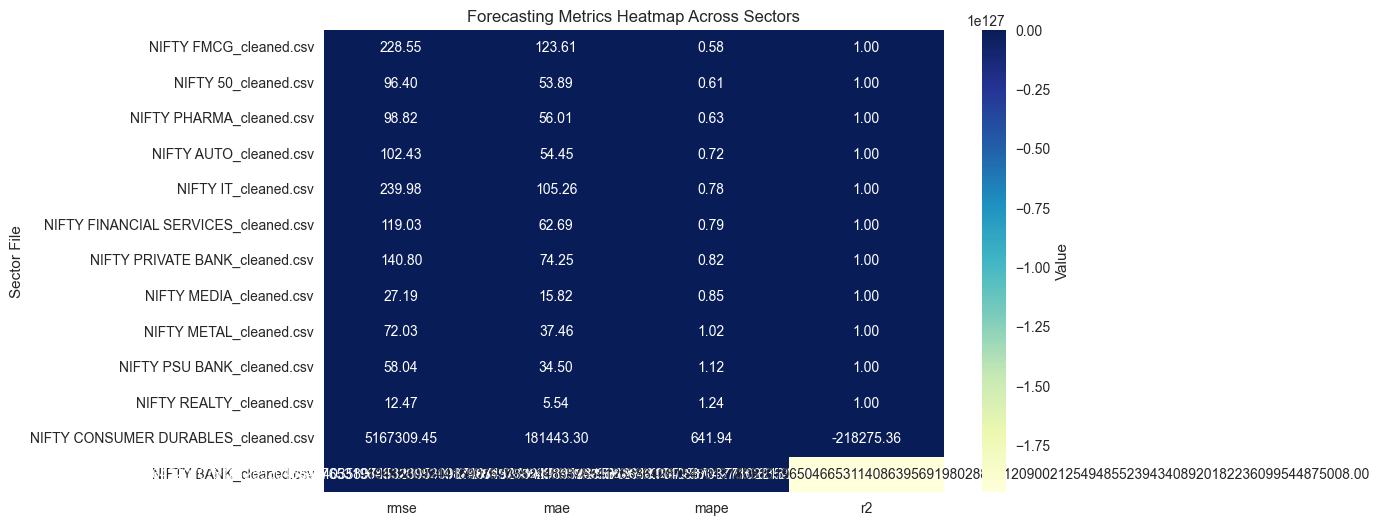

In [5]:
# 📌 Heatmap of Metrics
plt.figure(figsize=(10,6))
heatmap_data = metrics_df.set_index("file")[["rmse", "mae", "mape", "r2"]]
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={"label": "Value"})
plt.title("Forecasting Metrics Heatmap Across Sectors")
plt.ylabel("Sector File")
plt.show()